# Activation Patching by attention layers, mlps, and every token

In [11]:
from nnsight import LanguageModel
import torch
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import string
import os

In [12]:
llm = LanguageModel("meta-llama/Llama-3.2-3B", device_map="auto", torch_dtype=torch.float32)

In [13]:
N_LAYERS = llm.model.config.num_hidden_layers
N_HEADS = llm.model.config.num_attention_heads
hidden_size = llm.model.layers[0].self_attn.q_proj.weight.shape[0]
HEAD_SIZE = hidden_size // N_HEADS

In [14]:
def run_activation_patching(prompts, answer_token_indices):  
    patching_results = {layer: {"attn": {}, "mlp": {}} for layer in range(N_LAYERS)}  # Pre-allocate layer keys
    z_l = {}

    # Clean run, grab clean activations for layer
    with llm.trace(prompts[0]):
        clean_tokens = llm.inputs[1]["input_ids"][0].save()
        for layer in range(N_LAYERS):
            z_l[layer] = {
                "attn": llm.model.layers[layer].self_attn.output.save(),
                "mlp": llm.model.layers[layer].mlp.output.save()
            }
        # Get logits from lm_head
        clean_logits = llm.lm_head.output
        clean_logit_difference = (clean_logits[0, -1, answer_token_indices[0][0]] - clean_logits[0, -1, answer_token_indices[0][1]]).save()

    # Corrupted run, grab the corrupted logits for later comparison    
    with llm.trace(prompts[1]):
        corrupted_logits = llm.lm_head.output
        corrupted_logit_difference = (corrupted_logits[0, -1, answer_token_indices[0][0]] - corrupted_logits[0, -1, answer_token_indices[0][1]]).save()
    
    print(clean_tokens)

    # Patching
    # Start with the activation patching. We take the average of the clean and reversed activations and use the first prompt set for patching: iterate through all the layers
    for layer in range(N_LAYERS):
        print(layer)
        for token_idx in range(len(clean_tokens)):  
            with llm.trace(prompts[1]):
                # Activation patching MLP
                # mlp_output = llm.model.layers[layer].mlp.output.save() # for testing
                llm.model.layers[layer].mlp.output[:, token_idx, :] = z_l[layer]["mlp"][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["mlp"][f"token_{token_idx}"] = patched_result.item().save() 

            with llm.trace(prompts[1]):
                # Activation patching attention
                # self_attn_output = llm.model.layers[layer].self_attn.output.save() # for testing
                llm.model.layers[layer].self_attn.output[0][:, token_idx, :] = z_l[layer]["attn"][0][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["attn"][f"token_{token_idx}"] = patched_result.item().save() 

    patching_results = {
        "clean_run_logit_difference": clean_logit_difference,
        "corrupted_run_logit_difference": corrupted_logit_difference,
        "patching_results": patching_results    
    }

    return patching_results, clean_tokens 

In [15]:
def plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, patching_results_reversed, clean_tokens, corrupted_tokens, prompt_row, answers):
    # Plotting: Two heatmaps side by side with Attention and MLP interleaved on Y-axis
    N_LAYERS = len(patching_results["patching_results"])
    seq_len = len(clean_tokens)
    seq_len_corrupted = len(corrupted_tokens)

    # Extract data for attention and MLP for both patching_results and patching_results_reversed
    combined_effects = np.zeros((N_LAYERS * 2, seq_len))  # For patching_results
    combined_effects_reversed = np.zeros((N_LAYERS * 2, seq_len))  # For patching_results_reversed

    # Process patching_results
    for layer in range(N_LAYERS):
        for token_idx in range(seq_len):
            attn_effect = float(patching_results["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects[layer * 2, token_idx] = attn_effect      # Attention row
            combined_effects[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

    # Process patching_results_reversed
    for layer in range(N_LAYERS):
        for token_idx in range(seq_len):
            attn_effect = float(patching_results_reversed["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results_reversed["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects_reversed[layer * 2, token_idx] = attn_effect      # Attention row
            combined_effects_reversed[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

    clean_diff = float(patching_results["clean_run_logit_difference"].item())
    corrupted_diff = float(patching_results["corrupted_run_logit_difference"].item())
    clean_diff_reversed = float(patching_results_reversed["clean_run_logit_difference"].item())
    corrupted_diff_reversed = float(patching_results_reversed["corrupted_run_logit_difference"].item())

    # Create the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

    # Heatmap 1: patching_results
    im1 = ax1.imshow(combined_effects, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
    ax1.set_title('Example 1, Order 1', fontsize=14)

    # X-axis: Token labels for the first subplot
    token_labels = [llm.tokenizer.decode([tok]) for tok in clean_tokens]
    ax1.set_xticks(np.arange(seq_len))
    ax1.set_xticklabels(token_labels, fontsize=10, rotation=45, ha='right')

    # Y-axis: Interleave Attention and MLP labels for each layer (shared)
    y_labels = []
    for layer in range(N_LAYERS):
        y_labels.extend([f'Attn {layer}', f'MLP {layer}'])
    ax1.set_yticks(np.arange(N_LAYERS * 2))
    ax1.set_yticklabels(y_labels, fontsize=10)

    # Add grid lines to the first subplot, aligned with cell boundaries using minor ticks
    ax1.set_xticks(np.arange(seq_len + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax1.set_yticks(np.arange(N_LAYERS * 2 + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax1.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Heatmap 2: patching_results_reversed
    token_labels_corrupted = [llm.tokenizer.decode([tok]) for tok in corrupted_tokens]
    im2 = ax2.imshow(combined_effects_reversed, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
    ax2.set_title('Patching Effects (Reversed Order)', fontsize=14)

    # X-axis: Token labels for the second subplot
    ax2.set_xticks(np.arange(seq_len_corrupted))
    ax2.set_xticklabels(token_labels_corrupted, fontsize=10, rotation=45, ha='right')

    # Add grid lines to the second subplot, aligned with cell boundaries using minor ticks
    ax2.set_xticks(np.arange(seq_len_corrupted + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax2.set_yticks(np.arange(N_LAYERS * 2 + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid (shared with ax1)
    ax2.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add a shared colorbar, moved further to the right
    cbar = fig.colorbar(im2, ax=[ax1, ax2], label='Normalized Patching Effect', fraction=0.02, pad=0.1)

    # Add overall title and clean/corrupted context
    fig.suptitle(f'Patching Effects by Layer and Token\n(Clean: "{answers[0][0]}" vs Corrupted: "{answers[0][1]}")', fontsize=16, y=0.98)
    fig.text(0.5, 0.02, 
             f'Original Order: Clean Logit Diff: {clean_diff:.3f} | Corrupted Logit Diff: {corrupted_diff:.3f}\n'
             f'Reversed Order: Clean Logit Diff: {clean_diff_reversed:.3f} | Corrupted Logit Diff: {corrupted_diff_reversed:.3f}', 
             fontsize=11, ha='center')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15, right=0.85)  # Adjust right to make space for the colorbar

    # Save and show
    plt.savefig(f'patching_effects_heatmap_combined_{prompt_row}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
def plot_2x2_heatmaps(patching_results1, patching_results2, patching_results_reversed1, patching_results_reversed2, clean_tokens, clean_tokens_reversed, clean_tokens_2, clean_tokens_reversed_2, prompt_row):
    """
    Create a 2x2 grid of heatmaps showing patching effects for two examples in two different orders.
    
    Args:
        patching_results1: Patching results for first example, first order
        patching_results2: Patching results for second example, first order
        patching_results_reversed1: Patching results for first example, reversed order
        patching_results_reversed2: Patching results for second example, reversed order
        clean_tokens: Tokens for first example, first order
        clean_tokens_reversed: Tokens for first example, reversed order
        clean_tokens_2: Tokens for second example, first order
        clean_tokens_reversed_2: Tokens for second example, reversed order
        prompt_row: Row index for saving the figure
    """
    # Set up figure parameters
    FIGWIDTH = 10  # Increased figure width for more space
    SIZE = 7  # Increased from 6 to 8 for bigger font
    
    # Configure matplotlib settings
    setup_matplotlib_params(SIZE)
    
    # Extract and process patching data
    N_LAYERS = len(patching_results1["patching_results"])
    seq_len = len(clean_tokens)
    seq_len_2 = len(clean_tokens_2)

    # Process all patching results into combined effects matrices
    combined_effects = process_patching_results(
        patching_results1, patching_results2, 
        patching_results_reversed1, patching_results_reversed2,
        N_LAYERS, seq_len, seq_len_2
    )
    
    # Create and configure the figure
    fig, axes = plt.subplots(2, 2, figsize=(FIGWIDTH, FIGWIDTH))
    
    # Organize data for plotting
    data = combined_effects
    titles = ["Example 1, Order 1", "Example 1, Order 2", "Example 2, Order 1", "Example 2, Order 2"]
    tokens = [clean_tokens, clean_tokens_reversed, clean_tokens_2, clean_tokens_reversed_2]
    
    # Create each heatmap
    im = create_heatmaps(axes, data, titles, tokens, N_LAYERS, SIZE)
    
    # Add colorbar and finalize layout
    add_colorbar_and_finalize(fig, im, axes, SIZE, prompt_row)


def setup_matplotlib_params(size):
    """Configure matplotlib parameters for consistent styling"""
    plt.rc("font", size=size)
    plt.rc("axes", titlesize=size+3)  # Increased title size
    plt.rc("xtick", labelsize=size)
    plt.rc("ytick", labelsize=size)
    plt.rc("legend", fontsize=size)
    
    mpl.rcParams["figure.dpi"] = 300
    mpl.rcParams["savefig.dpi"] = 300


def process_patching_results(patching_results1, patching_results2, patching_results_reversed1, patching_results_reversed2, n_layers, seq_len, seq_len_2):
    """Process patching results into matrices for visualization"""
    # Initialize matrices to hold combined effects
    combined_effects1 = np.zeros((n_layers * 2, seq_len))  
    combined_effects2 = np.zeros((n_layers * 2, seq_len_2))
    combined_effects_reversed1 = np.zeros((n_layers * 2, seq_len))
    combined_effects_reversed2 = np.zeros((n_layers * 2, seq_len_2))

    # Extract values from patching results
    for layer in range(n_layers):
        for token_idx in range(seq_len):
            # First example, first order
            attn_effect = float(patching_results1["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results1["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects1[layer * 2, token_idx] = attn_effect
            combined_effects1[layer * 2 + 1, token_idx] = mlp_effect
            
            # First example, reversed order
            attn_effect = float(patching_results_reversed1["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results_reversed1["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects_reversed1[layer * 2, token_idx] = attn_effect
            combined_effects_reversed1[layer * 2 + 1, token_idx] = mlp_effect
            
    for layer in range(n_layers):
        for token_idx in range(seq_len_2):
            # Second example, first order
            attn_effect = float(patching_results2["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results2["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects2[layer * 2, token_idx] = attn_effect
            combined_effects2[layer * 2 + 1, token_idx] = mlp_effect
            
            # Second example, reversed order
            attn_effect = float(patching_results_reversed2["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results_reversed2["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects_reversed2[layer * 2, token_idx] = attn_effect
            combined_effects_reversed2[layer * 2 + 1, token_idx] = mlp_effect
    
    return [combined_effects1, combined_effects_reversed1, combined_effects2, combined_effects_reversed2]


def create_heatmaps(axes, data, titles, tokens, n_layers, size):
    """Create individual heatmaps in the 2x2 grid"""
    for i, (ax, d, title, toks) in enumerate(zip(axes.flatten(), data, titles, tokens)):
        # Create the heatmap
        im = ax.imshow(d, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
        ax.set_title(title, fontsize=size+3)  # Increased title size
        
        # Create token labels
        token_labels = [llm.tokenizer.decode([tok]) for tok in toks]

        # Replace first token with <bos>
        token_labels[0] = "<BOS>"

        ax.set_xticks(np.arange(len(token_labels)))
        
        # Set x-axis labels with rotation
        ax.set_xticklabels(token_labels, fontsize=size-1, rotation=45, ha='right', rotation_mode='anchor')  
        
        # Highlight " correct" token in red
        for j, label in enumerate(token_labels):
            if label == " correct":
                text = ax.get_xticklabels()[j]
                text.set_color('red')
                text.set_fontweight('bold')  # Make it bold for better visibility
        
        # Add Attn labels on the left side
        for layer in range(n_layers):
            ax.text(-0.01, layer * 2, f'Attn {layer}', 
                    fontsize=size, ha='right', va='center',  # Increased from size-1 to size
                    transform=ax.get_yaxis_transform())
        
        # Add MLP labels on the right side
        for layer in range(n_layers):
            ax.text(1.01, layer * 2 + 1, f'MLP {layer}', 
                    fontsize=size, ha='left', va='center',  # Increased from size-1 to size
                    transform=ax.get_yaxis_transform())

        # Remove y-axis ticks
        ax.set_yticks([])
        
        # Add grid lines
        ax.set_xticks(np.arange(len(token_labels) + 1) - 0.5, minor=True)
        ax.tick_params(axis='x', which='minor', length=0)  # hide the tick marks
        ax.set_yticks(np.arange(n_layers * 2 + 1) - 0.5, minor=True)
        ax.tick_params(axis='y', which='minor', length=0)  # hide the tick marks
        ax.grid(True, which='minor', color='gray', linestyle='-', linewidth=0.3, alpha=0.7)
        
    return im


def add_colorbar_and_finalize(fig, im, axes, size, prompt_row):
    """Add colorbar and finalize the figure layout"""
    # Add shared colorbar with more padding to move it further right
    cbar = fig.colorbar(im, ax=axes, label='Patching Effect', fraction=0.046, pad=0.18, location='right')
    # Move the colorbar further right with more spacing
    cbar.ax.tick_params(labelsize=size+1)  # Increased from size-1 to size
    cbar.set_label('Patching Effect', size=size+3)  # Increased from size to size+2
    
    # Center colorbar vertically
    cbar_ax = cbar.ax
    pos = cbar_ax.get_position()
    new_height = pos.height * 0.9
    new_y = pos.y0 + (pos.height - new_height) / 2 + 0.02
    cbar_ax.set_position([pos.x0, new_y, pos.width, new_height])

    # Adjust subplot space to give colorbar room
    plt.subplots_adjust(bottom=0.2, hspace=0.4, left=0.12, wspace=0.3, right=0.80)
    
    # Save figures in multiple formats
    save_figures(fig, prompt_row)
    
    plt.show()


def save_figures(fig, prompt_row):
    """Save the figure in both PDF and PNG formats"""
    fig.savefig(
        f'patching_effects_2x2_{prompt_row}_2B.pdf',
        format="pdf",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )
    
    fig.savefig(
        f'patching_effects_2x2_{prompt_row}_2B.png',
        format="png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

In [17]:
# Locate the current directory
current_dir = os.getcwd()
print(f"current_dir={current_dir}")
# Read from the csv file the sentences s1, s2, and last_sentence
df = pd.read_csv(os.path.join(current_dir, "sentences.csv"))
patching_results = []
patching_results_reversed = []

current_dir=/Users/ivannaranjo/Documents/Helmholtz/experiments/hlmz-prep/activation_patching_experiments


In [18]:
# Iterate over the rows of the dataframe and plot the patching effects for each row
for i in range(len(df)):
    s1 = df.iloc[i]["sentence1"]
    s2 = df.iloc[i]["sentence2"]
    last_sentence = df.iloc[i]["last_sentence"]

    prompt = f"{s1}\n{s2}\nNow I will give the correct answer.\n{last_sentence}"
    corrupted_prompt = f"{s1}\n{s2}\nNow I will give the incorrect answer.\n{last_sentence}"

    prompt_reversed = f"{s2}\n{s1}\nNow I will give the correct answer.\n{last_sentence}"   
    corrupted_prompt_reversed = f"{s2}\n{s1}\nNow I will give the incorrect answer.\n{last_sentence}"

    prompts = [prompt, corrupted_prompt]
    prompts_reversed = [prompt_reversed, corrupted_prompt_reversed]

    # Define the answers to these prompts, formatted as (correct, incorrect)
    answers = [
        (df.iloc[i]["answer_sentence1"], df.iloc[i]["answer_sentence2"]),
    ]

    answer_token_indices = [
        [llm.tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
        for i in range(len(answers))
    ]

    patching_result, clean_tokens = run_activation_patching(prompts, answer_token_indices)
    patching_result_reversed, clean_tokens_reversed = run_activation_patching(prompts_reversed, answer_token_indices)
    patching_results.append((patching_result, clean_tokens))
    patching_results_reversed.append((patching_result_reversed, clean_tokens_reversed))

    # plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, patching_results_reversed, clean_tokens, clean_tokens_reversed, i, answers)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.86s/it]
Some parameters are on the meta device because they were offloaded to the disk.


KeyboardInterrupt: 

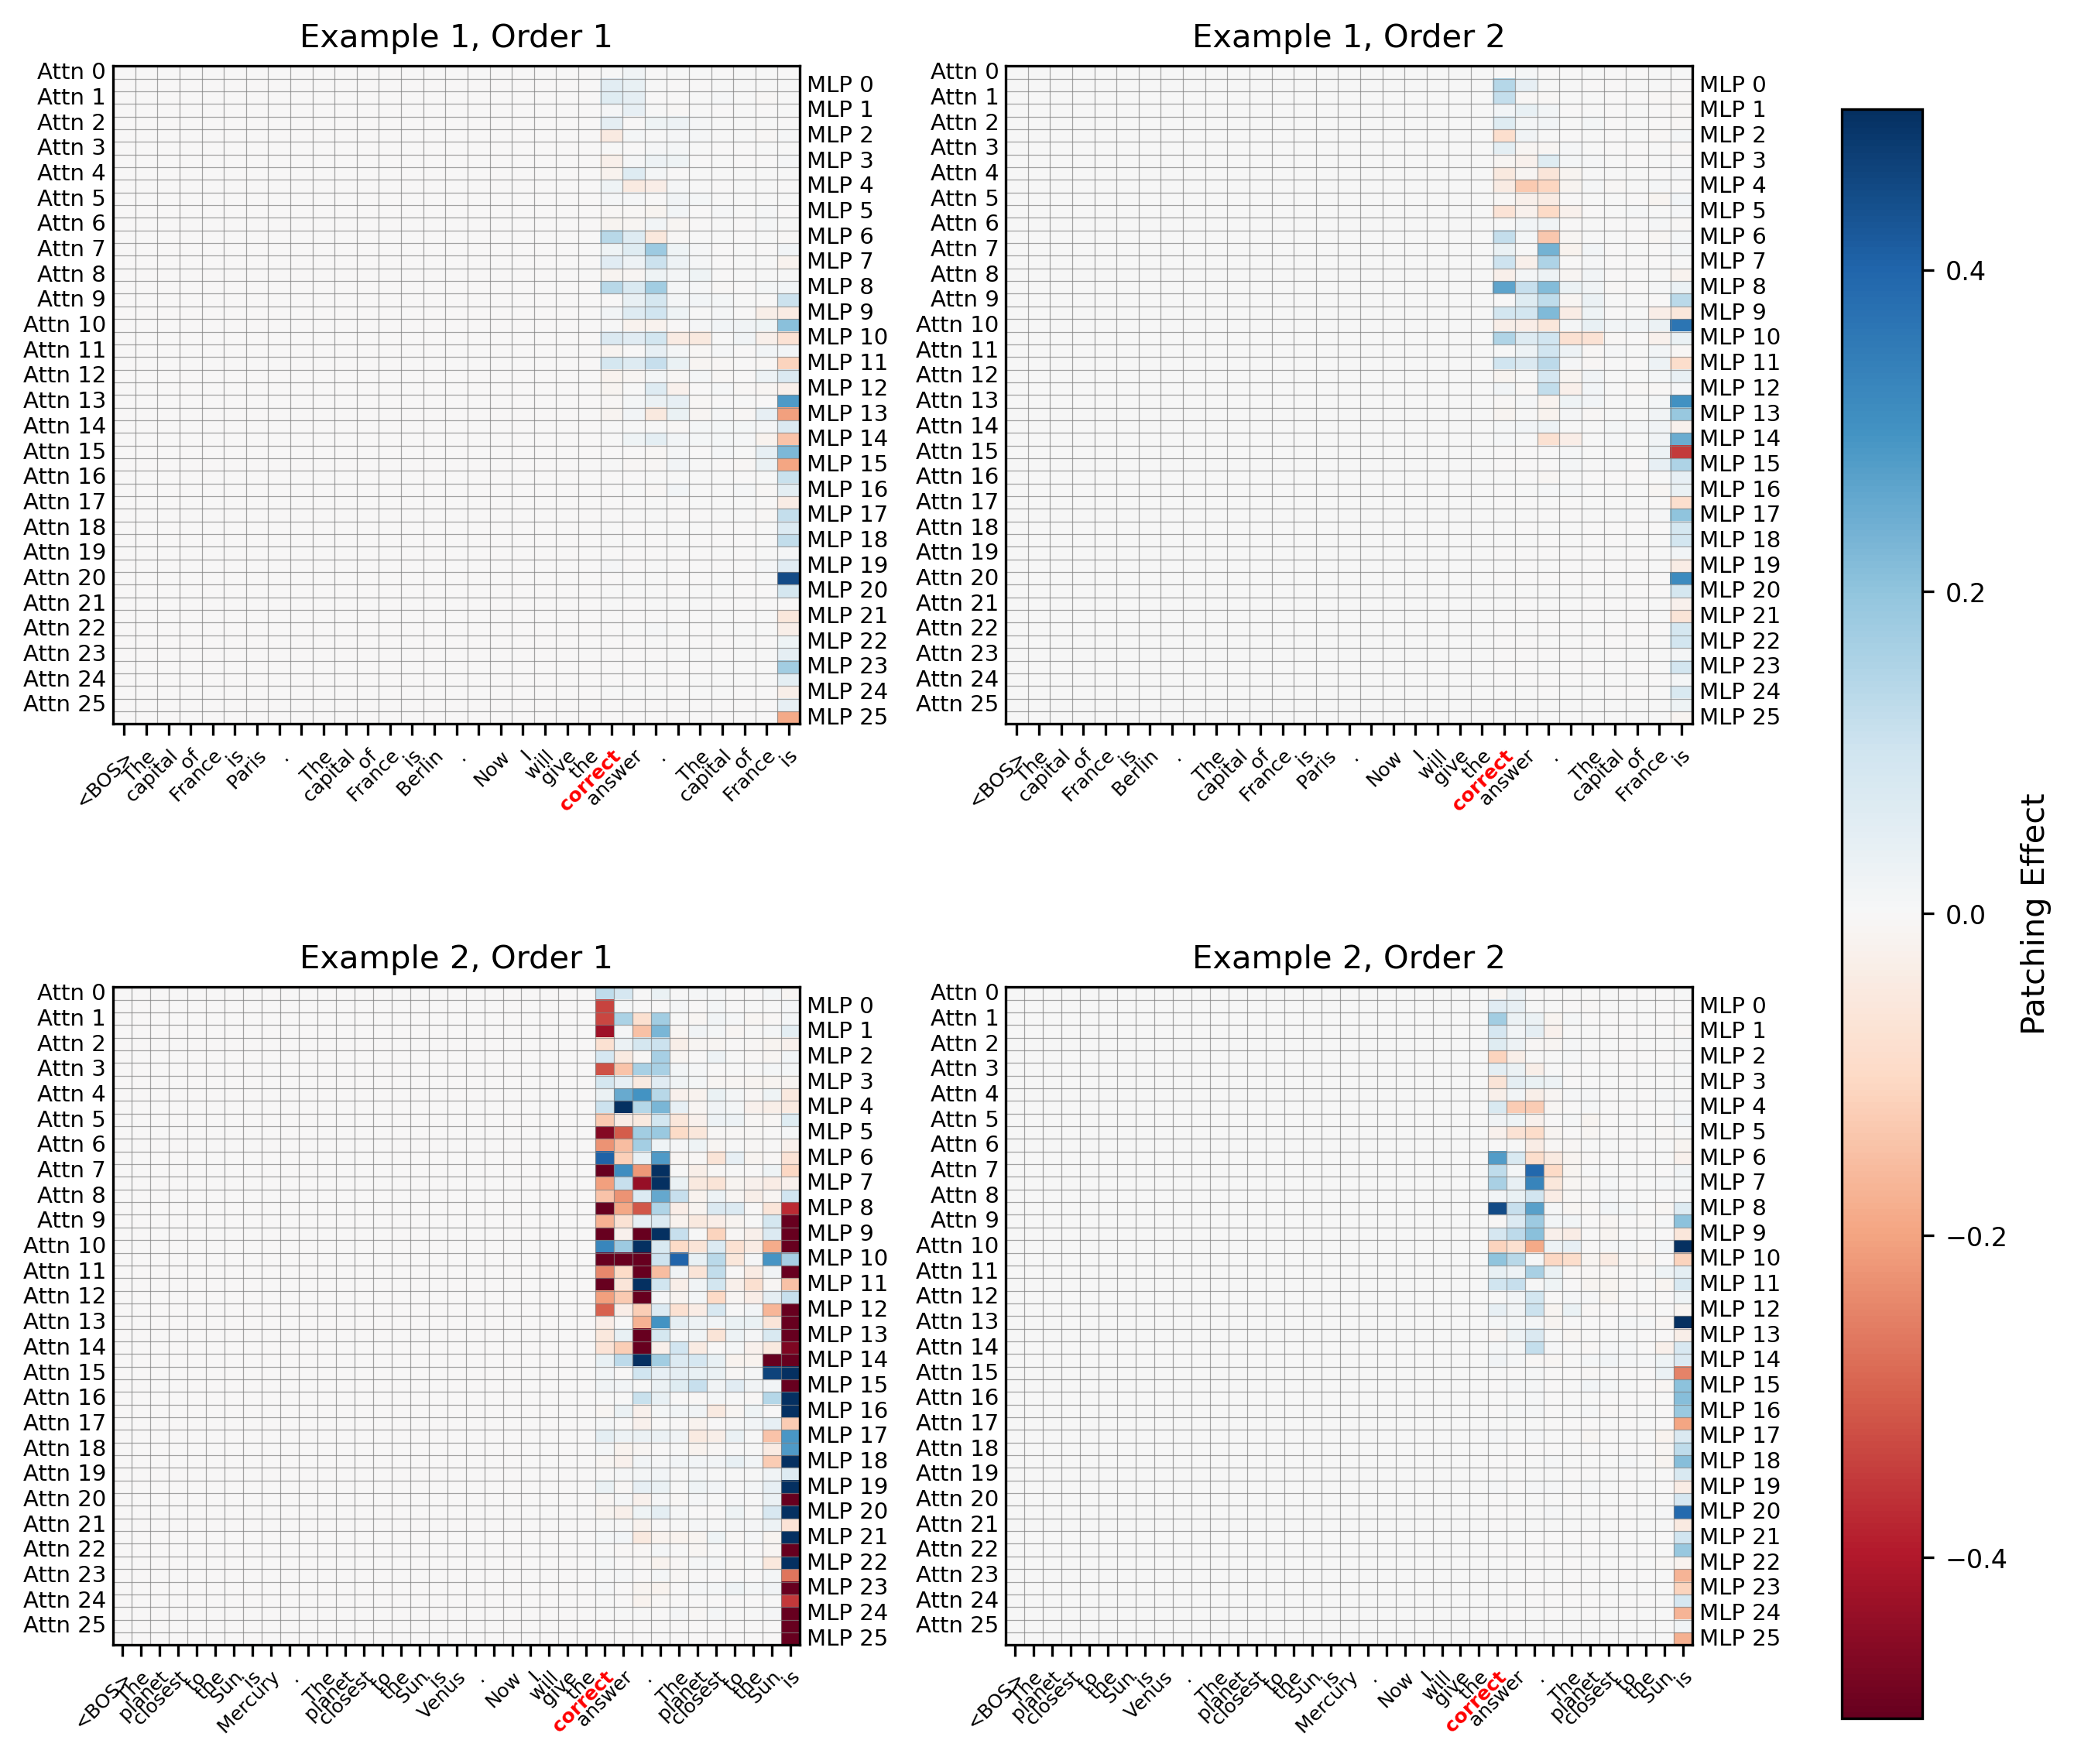

In [ ]:
# plot the 2x2 heatmaps together
plot_2x2_heatmaps(patching_results1=patching_results[0][0], patching_results2=patching_results[1][0], 
                  patching_results_reversed1=patching_results_reversed[0][0], patching_results_reversed2=patching_results_reversed[1][0], 
                  clean_tokens=patching_results[0][1], clean_tokens_reversed=patching_results_reversed[0][1], 
                  clean_tokens_2=patching_results[1][1], clean_tokens_reversed_2=patching_results_reversed[1][1], 
                  prompt_row=i)

In [19]:
def run_attention_head_patching(prompts, answer_token_indices, layers_to_patch):
    """
    Performs activation patching on individual attention heads for specified layers.

    Args:
        prompts (list): A list containing the clean and corrupted prompts.
        answer_token_indices (list): A list of token indices for the correct and incorrect answers.
        layers_to_patch (list): A list of layer indices to perform patching on.

    Returns:
        tuple: A tuple containing:
            - patching_results (dict): The results of the patching experiment.
            - clean_tokens (torch.Tensor): The tokenized clean prompt.
    """
    patching_results = {layer: {} for layer in layers_to_patch}
    clean_head_outputs = {layer: None for layer in layers_to_patch}

    # Clean run: get clean activations for each head in the specified layers
    with llm.trace(prompts[0]):
        clean_tokens = llm.inputs[1]['input_ids'][0].save()
        for layer in layers_to_patch:
            # The input to o_proj is the concatenated output of all heads.
            # Shape: (batch_size, seq_len, hidden_size) which is (batch_size, seq_len, N_HEADS * HEAD_SIZE)
            clean_head_outputs[layer] = llm.model.layers[layer].self_attn.o_proj.input.save()

        clean_logits = llm.lm_head.output
        clean_logit_difference = (clean_logits[0, -1, answer_token_indices[0][0]] - clean_logits[0, -1, answer_token_indices[0][1]]).save()

    # Corrupted run: get corrupted logits for baseline
    with llm.trace(prompts[1]):
        corrupted_logits = llm.lm_head.output
        corrupted_logit_difference = (corrupted_logits[0, -1, answer_token_indices[0][0]] - corrupted_logits[0, -1, answer_token_indices[0][1]]).save()

    # Patching run: iterate through specified layers and all heads
    for layer in layers_to_patch:
        print(f"Patching Layer {layer}...")
        for head in range(N_HEADS):
            with llm.trace(prompts[1]):
                # The input to o_proj is what we are patching. It's a tensor of shape
                # (batch, seq_len, N_HEADS * HEAD_SIZE). We slice it to get a single head's output.
                start_index = head * HEAD_SIZE
                end_index = (head + 1) * HEAD_SIZE
                
                # Patch the slice corresponding to the current head with the clean activation
                llm.model.layers[layer].self_attn.o_proj.input[:, :, start_index:end_index] = clean_head_outputs[layer][:, :, start_index:end_index]
                
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                
                # Normalize the result
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer][head] = patched_result.item().save()

    results = {
        "clean_run_logit_difference": clean_logit_difference,
        "corrupted_run_logit_difference": corrupted_logit_difference,
        "patching_results": patching_results
    }

    return results, clean_tokens


In [22]:
def plot_head_patching_heatmap(results, layers_to_patch, example_name):
    """
    Plots a heatmap of patching effects for individual attention heads.

    Args:
        results (dict): The results from the patching experiment.
        layers_to_patch (list): The layers that were patched.
        example_name (str): A name for the plot title and filename.
    """
    n_layers = len(layers_to_patch)
    
    # Create a matrix to hold the patching effects
    effects_matrix = np.zeros((n_layers, N_HEADS))
    
    for i, layer in enumerate(layers_to_patch):
        for head in range(N_HEADS):
            effects_matrix[i, head] = results["patching_results"][layer][head]

    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(effects_matrix, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)

    # Set labels and title
    ax.set_xticks(np.arange(N_HEADS))
    ax.set_xticklabels([f"H{h}" for h in range(N_HEADS)], rotation=90)
    ax.set_xlabel("Head")

    ax.set_yticks(np.arange(n_layers))
    ax.set_yticklabels([f"L{l}" for l in layers_to_patch])
    ax.set_ylabel("Layer")

    ax.set_title(f'Attention Head Patching Effects ({example_name})')
    
    # Add a colorbar
    fig.colorbar(im, ax=ax, label='Normalized Patching Effect')

    # Add grid lines
    ax.set_xticks(np.arange(N_HEADS + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_layers + 1) - 0.5, minor=True)
    ax.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(f'patching_effects_heads_{example_name}.pdf', format='pdf', dpi=300)
    plt.show()


Patching Layer 2...
Patching Layer 5...
Patching Layer 14...
Patching Layer 21...


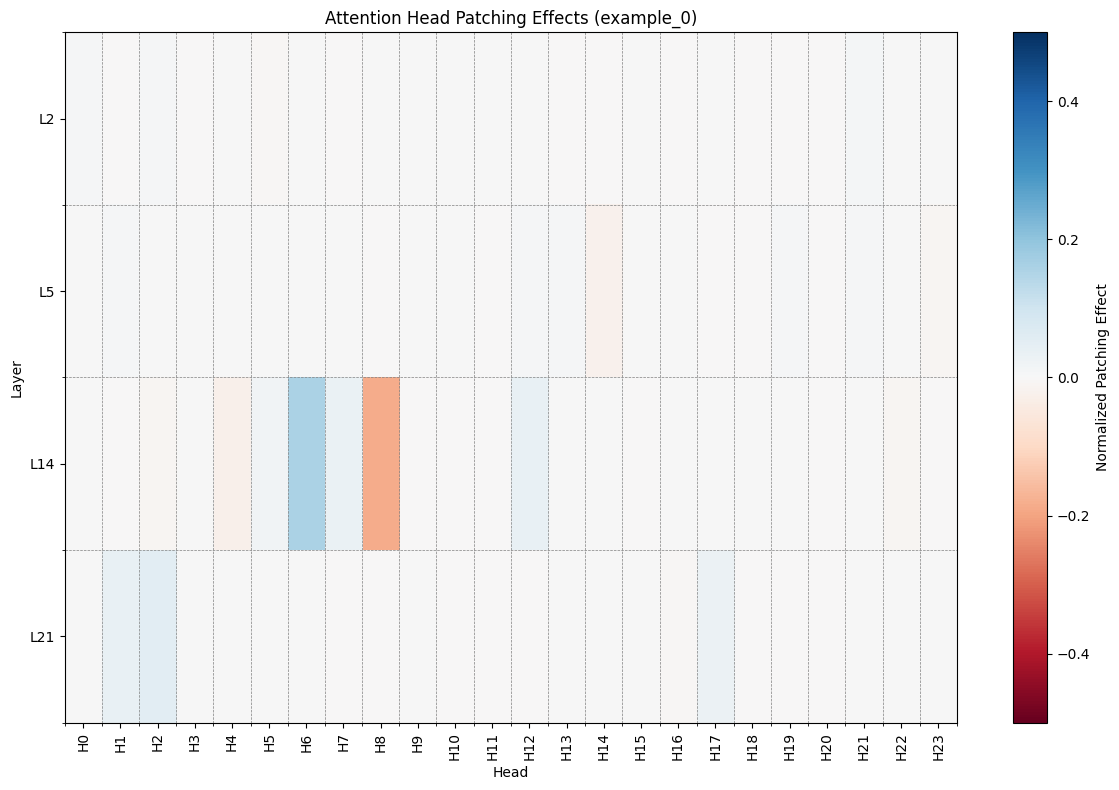

In [23]:
# Define the layers to patch
layers_to_patch = [2, 5, 14, 21]

# Use the first example from your dataframe for this experiment
i = 0
s1 = df.iloc[i]["sentence1"]
s2 = df.iloc[i]["sentence2"]
last_sentence = df.iloc[i]["last_sentence"]

prompt = f"{s1}\n{s2}\nNow I will give the correct answer.\n{last_sentence}"
corrupted_prompt = f"{s1}\n{s2}\nNow I will give the incorrect answer.\n{last_sentence}"
prompts = [prompt, corrupted_prompt]

answers = [(df.iloc[i]["answer_sentence1"], df.iloc[i]["answer_sentence2"])]
answer_token_indices = [[llm.tokenizer(answers[0][j])["input_ids"][1] for j in range(2)]]

# Run the attention head patching experiment
head_patching_results, _ = run_attention_head_patching(prompts, answer_token_indices, layers_to_patch)

# Plot the results
plot_head_patching_heatmap(head_patching_results, layers_to_patch, f"example_{i}")
